# Differentiable Logic Gate Network Hardware Generation via Mase

**_Description_**

Recently proposed differentiable logic gate networks provide state of the art performance while keeping the network size small and the hardware requirements low. This project aims to implement the key components of the logic gate network in hardware for Mase.

**_Key Elements_**

- Implement logic network components, namely logic gate and group-sum layers, and write a testbench to verify their correctness.
- Connect hardware to Mase Verilog emit pass for automatic hardware generation.

**_Extensions_**

- Evaluate generated hardware's latency and resource usage against same-category models, e.g. LUTNets.

**_Reference_**

- Deep Differentiable Logic Gate Networks: [https://arxiv.org/pdf/2210.08277](https://arxiv.org/pdf/2210.08277)


## Part 0: Quick Intro For Differentiable Logic Gate Networks

Differentiable Logic Gate Networks ("difflogic") uses a network of randomly connected 2-input 1-output logic gates as neurons to perform deep learning tasks (Fig. 1). Models are trained through a relaxation of the logic operations (Fig. 2), but only one gate type is selected for each neuron for inference. For single-label classification tasks, a group sum module is introduced at the end, where the group with the largest number of 1s is determined as the predicted label. In this notebook we demo the generation of a pre-trained difflogic network operating on the MNIST dataset.

_Figure 1: Diagram of Differentiable Logic Gate Networks_

![](img/difflogic/diagram.png)

_Figure 2: Logic Gate Operations and Relaxations_

![](img/difflogic/logic-ops.png)


## Part 1: Generating Mase Graph

**_Key Contributions_**

- Using Mase's `custom_ops` argument to work with `difflogic`'s custom layers.


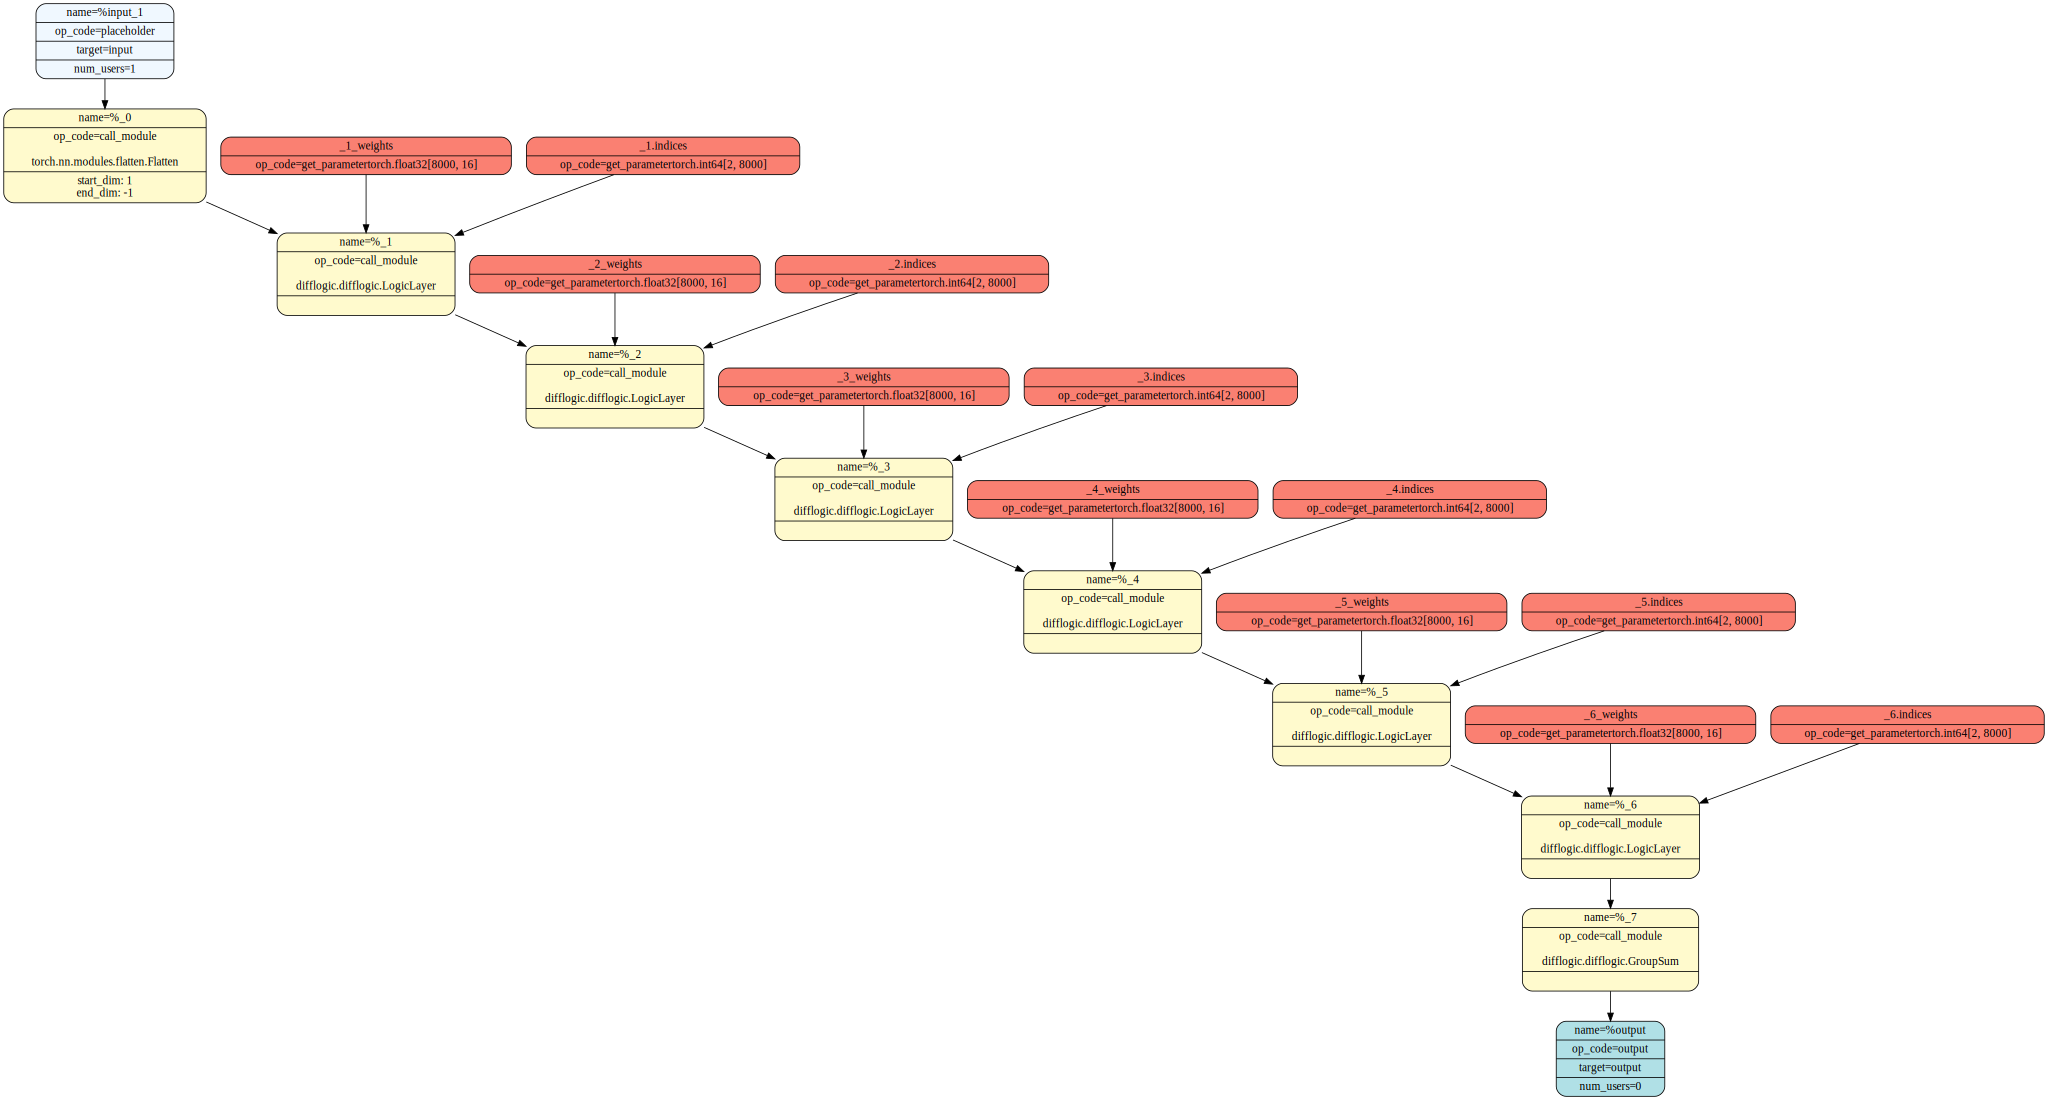

In [1]:
import torch
from chop import MaseGraph
from difflogic import LogicLayer, GroupSum
from IPython.display import SVG, display


# setup small difflogic model

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    LogicLayer(400, 8_000),
    LogicLayer(8_000, 8_000),
    LogicLayer(8_000, 8_000),
    LogicLayer(8_000, 8_000),
    LogicLayer(8_000, 8_000),
    LogicLayer(8_000, 8_000),
    GroupSum(k=10, tau=20)
)


# provide custom_ops argument to Mase

CUSTOM_OPS = {
    "modules": {
        LogicLayer: {
            "args": {
                "input": "data_in"
            },
            "toolchain": "INTERNAL_RTL",
            "module": "fixed_difflogic_logic",
            "dependence_files": [
                "difflogic_layers/rtl/fixed_difflogic_logic.sv",
                "difflogic_layers/rtl/fixed_difflogic_logic_neuron.sv",
            ],
        },
        GroupSum: {
            "args": {
                "input": "data_in"
            },
            "toolchain": "INTERNAL_RTL",
            "module": "fixed_difflogic_groupsum",
            "dependence_files": [
                "difflogic_layers/rtl/fixed_difflogic_groupsum.sv",
            ],
        },
    },
    "functions": {},
}


# generate and display mase graph

mg = MaseGraph(model, custom_ops=CUSTOM_OPS)
mg.draw("img/difflogic.svg")

SVG("img/difflogic.svg")

In [2]:
import mnist_dataset
from chop.passes import init_metadata_analysis_pass, \
                        add_common_metadata_analysis_pass

# load pre-trained mnist model

state_dict = torch.load("data-model/best_model_full.pth", map_location=torch.device('cpu'))
mg.model.load_state_dict(state_dict, strict=False)


# get dummy imput data

test_set = mnist_dataset.MNIST('./data-mnist', train=False, remove_border=True, download=True)
dummy_in_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=True, drop_last=True)
image, _ = next(iter(dummy_in_loader))
image = image.cpu().squeeze(0)


# add metadata by sending dummy input in

mg, _ = init_metadata_analysis_pass(mg)
mg, _ = add_common_metadata_analysis_pass(mg, pass_args={"dummy_in": {"input_1": image} })

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [3]:
# inspect metadata

def print_common_metadata_pass(graph):
    for node in graph.nodes:
        print(node.op)
        for k, v in node.meta["mase"]["common"].items():
            print(f"{k}: {v}")
        print()
    return mg, None

mg, _ = print_common_metadata_pass(mg)

placeholder
mase_type: placeholder
mase_op: placeholder
args: {}
results: OrderedDict([('data_out_0', {'type': 'float', 'precision': [32], 'shape': [1, 20, 20], 'torch_dtype': torch.float32, 'value': tensor([[[0.0000, 0.0000, 0.3294, 0.7255, 0.6235, 0.5922, 0.2353, 0.1412,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.8706, 0.9961, 0.9961, 0.9961, 0.9961, 0.9451,
          0.7765, 0.7765, 0.7765, 0.7765, 0.7765, 0.7765, 0.7765, 0.7765,
          0.6667, 0.2039, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.2627, 0.4471, 0.2824, 0.4471, 0.6392, 0.8902,
          0.9961, 0.8824, 0.9961, 0.9961, 0.9961, 0.9804, 0.8980, 0.9961,
          0.9961, 0.5490, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0667,
          0.2588, 0.0549, 0.2627, 0.2627, 0.2627, 0.2314, 0.0824, 0.9255,
          0.9961, 0.4157, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.

## Part 2: Generating Hardware

**_Key Contributions_**

- Parameterized diff logic gate network hardware designs:
  - [`fixed_difflogic_logic.sv`](../../../src/mase_components/difflogic_layers/rtl/fixed_difflogic_logic.sv)
  - [`fixed_difflogic_logic_neuron.sv`](../../../src/mase_components/difflogic_layers/rtl/fixed_difflogic_logic_neuron.sv)
  - [`fixed_difflogic_logic_groupsum.sv`](../../../src/mase_components/difflogic_layers/rtl/fixed_difflogic_groupsum.sv)
  - [`fixed_difflogic_logic_flatten.sv`](../../../src/mase_components/difflogic_layers/rtl/fixed_difflogic_flatten.sv)
- Augmented Mase passes:
  - [`add_hardware_metadata_analysis_pass`](../../../src/chop/passes/graph/analysis/add_metadata/add_hardware_metadata.py):Pass generates Verilog parameters for top design, we augmented this to incorporate logic gate network "weights" as parameters.
  - [`emit_verilog_top_transform_pass`](../../../src/chop/passes/graph/transforms/verilog/emit_top.py): Minor patches to glue all changes together.
- Work-around passes:
  - [`difflogic_hardware_metadata_optimize_pass`](../../../src/mase_components/difflogic_layers/passes.py): Since "weights" are embedded in hardware generation, we wrote a pass to remove the weight information from common metadata to stop Mase from generating extra BRAM.
  - [`difflogic_hardware_force_fixed_flatten_pass`](../../../src/mase_components/difflogic_layers/passes.py): Torch's `Flatten` module uses internal HLS, which is not setup. Running this pass forces Mase to use our version of the flatten hardware.

**_Quick Links_**

- Generated hardware location: `/root/.mase/top/hardware/rtl/`

In [4]:
from chop.passes.graph.analysis.add_metadata import add_hardware_metadata_analysis_pass
from mase_components.difflogic_layers.passes import difflogic_hardware_force_fixed_flatten_pass, \
                                                    difflogic_hardware_metadata_optimize_pass

# add hardware information

mg, _ = difflogic_hardware_metadata_optimize_pass(mg)
mg, _ = add_hardware_metadata_analysis_pass(mg)
mg, _ = difflogic_hardware_force_fixed_flatten_pass(mg)

In [5]:
# inspect hardware metadata

def print_hardware_metadata_pass(graph):
    for node in graph.nodes:
        print(node.op)
        for k, v in node.meta["mase"]["hardware"].items():
            print(f"{k}: {v}")
        print()
    return mg, None

mg, _ = print_hardware_metadata_pass(mg)

placeholder
is_implicit: True
device_id: 0
max_parallelism: [4, 4, 4, 4]

call_module
is_implicit: False
device_id: -1
interface: {}
toolchain: INTERNAL_RTL
module: fixed_difflogic_flatten
dependence_files: ['difflogic_layers/rtl/fixed_difflogic_flatten.sv']
max_parallelism: [4, 4, 4, 4]
verilog_param: {'DATA_IN_0_TENSOR_SIZE_DIM_0': 20, 'DATA_IN_0_TENSOR_SIZE_DIM_1': 20, 'DATA_OUT_0_TENSOR_SIZE_DIM_0': 400}

call_module
difflogic_args: {'weights': {'type': 'float', 'precision': [32], 'shape': [8000, 16], 'from': None, 'value': Parameter containing:
tensor([[-3.1171, -3.0228, -3.3257,  ..., -2.4036, -0.3832, -0.4898],
        [-5.3392, -5.0056, -5.7966,  ..., -4.3592, -5.0173, -5.3013],
        [-2.9236, -3.1242, -2.6519,  ..., -3.2646, -3.3187, -3.3288],
        ...,
        [-1.2249, 13.0285, -4.0221,  ..., -5.0735, -6.0271, -5.8215],
        [-2.3252, -3.2661, -2.0738,  ..., -4.0397, -3.9529, -4.0368],
        [-6.3166, -6.1052, -6.0224,  ..., -2.2150, -1.7534, 12.1391]],
       req

In [6]:
from chop.passes.graph.transforms.verilog import emit_verilog_top_transform_pass, \
                                                 emit_internal_rtl_transform_pass, \
                                                 emit_bram_transform_pass

# generate hardware
             
mg, _ = emit_verilog_top_transform_pass(mg)
mg, _ = emit_internal_rtl_transform_pass(mg)
mg, _ = emit_bram_transform_pass(mg)

## Part 3: Simulating and Testing

**_Key Contributions_**

- [`emit_cocotb_transform_pass`](../../../src/chop/passes/graph/transforms/verilog/emit_tb.py): Parse input into hardware format, i.e. round and concat binary numbers.
- [`simulate`](../../../src/chop/actions/simulate.py): Added Verilog arguments.

**_Quick Links_**

- Generated test location: `/root/.mase/top/hardware/test/`


In [7]:
from chop.passes.graph.transforms.verilog import emit_cocotb_transform_pass

# emit testbench

mg, _ = mg, _ = emit_cocotb_transform_pass(mg)

In [8]:
from chop.actions import simulate

# simulate with random image
# (design was pre-built, as building takes more than 10m)

simulate(skip_build=True, skip_test=False, build_jobs=10, unroll_count=10000)

INFO: Running command /workspace/mase-DLG/docs/DLG/demo/sim_build/top in directory /workspace/mase-DLG/docs/DLG/demo/sim_build
     -.--ns INFO     gpi                                ..mbed/gpi_embed.cpp:76   in set_program_name_in_venv        Did not detect Python virtual environment. Using system-wide Python interpreter
     -.--ns INFO     gpi                                ../gpi/GpiCommon.cpp:101  in gpi_print_registered_impl       VPI registered
     0.00ns INFO     cocotb                             Running on Verilator version 5.020 2024-01-01
     0.00ns INFO     cocotb                             Running tests with cocotb v1.8.0 from /usr/local/lib/python3.11/dist-packages/cocotb
     0.00ns INFO     cocotb                             Seeding Python random module with 1742168332
     0.00ns INFO     cocotb.regression                  Found test mase_top_tb.test.test
     0.00ns INFO     cocotb.regression                  running test (1/1)


/workspace/mase-DLG/src/mase_cocotb/driver.py:25: DeprecationWarning: This method is now private.
  self._thread = cocotb.scheduler.add(self._send_thread())
/workspace/mase-DLG/src/mase_cocotb/monitor.py:27: DeprecationWarning: This method is now private.
  self._thread = cocotb.scheduler.add(self._recv_thread())


    60.00ns DEBUG    cocotb.driver.StreamDriver         Sent [230050, 919659, 97477, 390107, 212246, 944643, 870411, 90183, 308384, 142909, 299939, 621614, 137563, 598942, 334009, 971226, 1028603, 715500, 985208, 624381]
    80.00ns DEBUG    cocotb.monitor.StreamMonitor       Observed output beat [375, 332, 412, 355, 387, 354, 378, 310, 441, 364]
    80.00ns DEBUG    cocotb.monitor.StreamMonitor       Got [375, 332, 412, 355, 387, 354, 378, 310, 441, 364], Expected tensor([[19.5339, 16.5054, 20.3809, 18.0921, 18.7915, 17.8383, 18.5446, 16.7061,
                                                                 21.7791, 18.3374]], grad_fn=<DivBackward0>)
    80.00ns INFO     cocotb.monitor.StreamMonitor       Monitor has been drained.
    80.00ns INFO     cocotb.regression                  test passed
    80.00ns INFO     cocotb.regression                  **************************************************************************************
                                               

/usr/lib/python3.11/tempfile.py:1073: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/tmp1cya09cu'>
  _warnings.warn(warn_message, ResourceWarning)


- :0: Verilog $finish


INFO     Test finished. Time taken: 9.87s


INFO: Results file: /workspace/mase-DLG/docs/DLG/demo/sim_build/results.xml


## Part 4: Synthesis and Performance Evaluation

Design was synthesized via Vivado with the following results.


**_Design Organizaiton_**

_Figure 3: Top Module_

![](img/design/design-diagram-top.jpeg)

_Figure 4: Generated Logic Network Module_

![](img/design/design-diagram-difflogic.jpeg)

**_Resource Usage_**

_Figure 5: Post-Synthesis Resource Usage_

![](img/perf/resource-post-syn.jpeg)

_Figure 6: Post-Implementation Resource Usage_

![](img/perf/resource-post-imp.jpeg)

**_Timing_**

Timing constraints was set to 50MHz clock, which met timing constrainsts, meaning that upperbound on latency is 20ns.

_Figure 7: Timing Slack_

![](img/perf/timing-slack.png)

## Part 5: Remaining Work

- Test generation toolchain against different models and datasets.
- Plot generation toolchain's resource usage vs. accuracy frontier.